In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
from shapely.geometry import Polygon
import matplotlib.pyplot as plt

In [2]:
nwcg = pd.read_csv(filepath_or_buffer = '/bsuhome/yavarpourmohamad/scratch/Dissertation/Code/Karen_email/NWCG_UnitIdActive_20200123.csv', sep = ',')
cols_FPA = ['STATE', 'FIRE_YEAR', 'DISCOVERY_DATE', 'NWCG_GENERAL_CAUSE', 'LONGITUDE', 'LATITUDE']
FPA_FOD = pd.read_csv(filepath_or_buffer = '/bsuhome/yavarpourmohamad/scratch/Dissertation/Data/FPA_FOD/FPA_FOD_Plus.csv',
                      sep = ',', low_memory = False)
sts = ['WA', 'OR', 'CA', 'ID', 'NV', 'MT', 'WY', 'UT', 'AZ', 'CO', 'NM']
sts.sort()
FPA_FOD = FPA_FOD.loc[FPA_FOD['STATE'].isin(sts)]
FPA_FOD = FPA_FOD.loc[FPA_FOD['LONGITUDE'] < -102.05]
FPA_FOD = pd.merge(left = FPA_FOD,
                   left_on = 'NWCG_REPORTING_UNIT_ID',
                   right = nwcg[['UnitId', 'UnitType']],
                   right_on = 'UnitId',
                   how = 'left')
FPA_FOD = FPA_FOD[~((FPA_FOD['FIRE_SIZE'] <= 0.1) & (FPA_FOD['Land_Cover'].isin([22, 23, 24])) & (FPA_FOD['UnitType'].isin(['US County/Local'])))]
FPA_FOD = FPA_FOD[cols_FPA]
cause_dic =  {'Debris and open burning': 'Debris',
              'Arson/incendiarism': 'Arson',
              'Recreation and ceremony': 'Recreation',
              'Missing data/not specified/undetermined': 'Missing',
              'Equipment and vehicle use': 'Equipment',
              'Power generation/transmission/distribution': 'Power',
              'Misuse of fire by a minor': 'Misuse by minor',
              'Firearms and explosives use': 'Firearms',
              'Railroad operations and maintenance': 'Railroad'}
FPA_FOD['NWCG_GENERAL_CAUSE'] = FPA_FOD['NWCG_GENERAL_CAUSE'].replace(cause_dic)              
FPA_FOD = FPA_FOD[~FPA_FOD['NWCG_GENERAL_CAUSE'].isin(['Other causes', 'Missing'])]
FPA_FOD = FPA_FOD.loc[FPA_FOD['FIRE_YEAR'] > 2015, ]

In [3]:
states = gpd.read_file(filename = '/bsuhome/yavarpourmohamad/scratch/FPA_FOD_Paper/Grid_variable_map/States/cb_2018_us_state_500k.shp')
states = states[['STUSPS', 'NAME', 'geometry']]
states = states.to_crs('EPSG:4326')
states = states.loc[states['STUSPS'].isin(sts)]

xmin, ymin, xmax, ymax = states.total_bounds

length = 0.45
wide = 0.45

cols = list(np.arange(xmin, xmax + wide, wide))
rows = list(np.arange(ymin, ymax + length, length))

polygons = []
for x in cols[:-1]:
    for y in rows[:-1]:
        polygons.append(Polygon([(x, y),
                                 (x + wide, y),
                                 (x + wide, y + length),
                                 (x, y + length)]))

grid = gpd.GeoDataFrame({'geometry':polygons, 'const': 1})
grid.crs = 'EPSG:4326'

# Annual

## Circle Map

In [8]:
FPA_FOD = gpd.GeoDataFrame(data = FPA_FOD,
                           crs = 'EPSG:4326',
                           geometry = gpd.points_from_xy(FPA_FOD.LONGITUDE, FPA_FOD.LATITUDE))
pointsinpolygon = gpd.sjoin(left_df = FPA_FOD,
                            right_df = grid,
                            how = 'inner',
                            predicate = 'intersects')
cause_counts = pointsinpolygon.groupby(['index_right', 'NWCG_GENERAL_CAUSE']).size().reset_index(name='count')
dominant_causes = cause_counts.sort_values('count', ascending=False)
dominant_causes = dominant_causes.drop_duplicates(subset=['index_right'], keep='first')

grid_with_counts = grid.merge(dominant_causes, left_index=True, right_on='index_right')
grid_with_counts['centroid'] = grid_with_counts.geometry.centroid
grid_with_counts['longitude'] = grid_with_counts.centroid.x
grid_with_counts['latitude'] = grid_with_counts.centroid.y

/tmp/ipykernel_237665/1443817818.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_with_counts['centroid'] = grid_with_counts.geometry.centroid
/tmp/ipykernel_237665/1443817818.py:14: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_with_counts['longitude'] = grid_with_counts.centroid.x
/tmp/ipykernel_237665/1443817818.py:15: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_with_counts['latitude'] = grid_with_counts.centroid.y


In [9]:
newCmapp = {
    'Power': '#a6cee3',
    'Equipment': '#1f78b4',
    'Recreation': '#b2df8a',
    'Debris': '#33a02c',
    'Arson': '#fb9a99',
    'Misuse by minor': '#e31a1c',
    'Natural': '#fdbf6f',
    'Firearms': '#ff7f00',
    'Fireworks': '#cab2d6',
    'Railroad': '#ffff99',
    'Smoking': '#b15928'
}
grid_with_counts['plot_color'] = grid_with_counts['NWCG_GENERAL_CAUSE'].map(newCmapp)

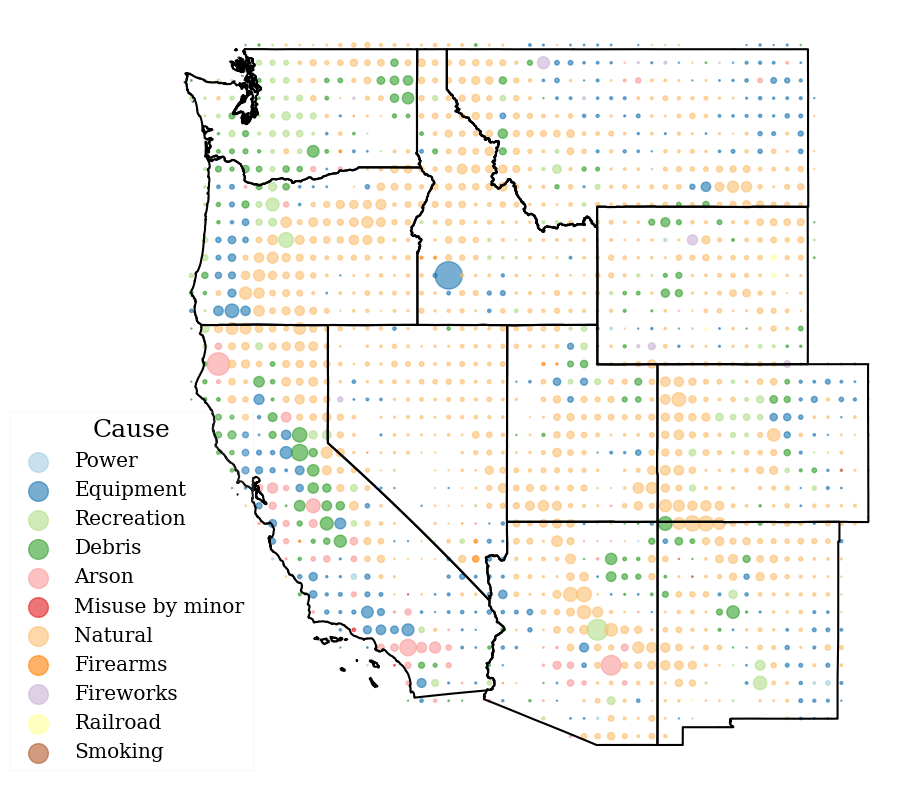

In [10]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
states.boundary.plot(ax=ax, edgecolor='black', linewidth=1.5)
scatter = ax.scatter(grid_with_counts.longitude,
                     grid_with_counts.latitude,
                     s=grid_with_counts['count'] * 0.25,  # Adjust the scaling factor as needed
                     c=grid_with_counts['plot_color'],
                     alpha=0.6,
                     edgecolors= 'face', # 'k'
                     label='Dominant Fire Cause')

legend_handles = []
legend_labels = []
for cause, color in newCmapp.items():
    legend_handles.append(plt.scatter([], [], color=color, alpha=0.6, edgecolors='face', s=200)) # , marker='s'
    legend_labels.append(cause)

ax.legend(handles=legend_handles,
          labels= legend_labels,
          title='Cause',
          bbox_to_anchor=(-0.2, 0),
          loc='lower left',
          title_fontsize=18,
          fontsize=14.5,
          fancybox=False,
          framealpha=0.1)
ax.set_xticks([])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticks([])
ax.axis('off')
plt.show()

## Stacked Barplot

In [25]:
total = FPA_FOD.groupby(by=['STATE', 'NWCG_GENERAL_CAUSE']).size().reset_index(name='Counts')
total = total.pivot(index='STATE', columns='NWCG_GENERAL_CAUSE', values='Counts').reset_index()

In [15]:
causes = ['Natural', 'Debris', 'Fireworks', 'Arson', 'Recreation', 'Smoking',
          'Equipment', 'Power', 'Misuse by minor', 'Firearms', 'Railroad']

([<matplotlib.axis.XTick at 0x2aab020f22d0>,
 [Text(0, 0, 'AZ'),
  Text(1, 0, 'CA'),
  Text(2, 0, 'CO'),
  Text(3, 0, 'ID'),
  Text(4, 0, 'MT'),
  Text(5, 0, 'NM'),
  Text(6, 0, 'NV'),
  Text(7, 0, 'OR'),
  Text(8, 0, 'UT'),
  Text(9, 0, 'WA'),
  Text(10, 0, 'WY')])

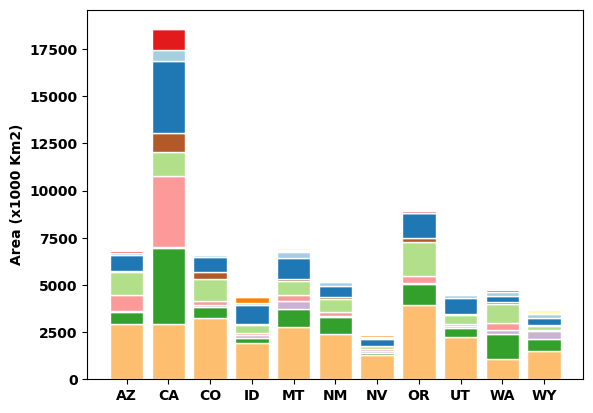

In [27]:
st_position = np.arange(len(causes))
natural = total.loc[:, causes[0]]
debris = total.loc[:, causes[1]]
fireworks = total.loc[:, causes[2]]
arson = total.loc[:, causes[3]]
recreation = total.loc[:, causes[4]]
smoking = total.loc[:, causes[5]]
equipment = total.loc[:, causes[6]]
power = total.loc[:, causes[7]]
misuse = total.loc[:, causes[8]]
firearms = total.loc[:, causes[9]]
railroad = total.loc[:, causes[10]]

# plt.bar(st_position, total['area']/1000, color='#bdbdbd', edgecolor='white', width=1)
plt.bar(st_position, natural, color='#fdbf6f', edgecolor='white', width=0.8)
plt.bar(st_position, debris, bottom=natural, color='#33a02c', edgecolor='white', width=0.8)
plt.bar(st_position, fireworks, bottom=natural+debris, color='#cab2d6', edgecolor='white', width=0.8)
plt.bar(st_position, arson, bottom=natural+debris+fireworks, color='#fb9a99', edgecolor='white', width=0.8)
plt.bar(st_position, recreation, bottom=natural+debris+fireworks+arson, color='#b2df8a', edgecolor='white', width=0.8)
plt.bar(st_position, smoking, bottom=natural+debris+fireworks+arson+recreation, color='#b15928', edgecolor='white', width=0.8)
plt.bar(st_position, equipment, bottom=natural+debris+fireworks+arson+recreation+smoking, color='#1f78b4', edgecolor='white', width=0.8)
plt.bar(st_position, power, bottom=natural+debris+fireworks+arson+recreation+smoking+equipment, color='#a6cee3', edgecolor='white', width=0.8)
plt.bar(st_position, misuse, bottom=natural+debris+fireworks+arson+recreation+smoking+equipment+power, color='#e31a1c', edgecolor='white', width=0.8)
plt.bar(st_position, firearms, bottom=natural+debris+fireworks+arson+recreation+smoking+equipment+power+misuse, color='#ff7f00', edgecolor='white', width=0.8)
plt.bar(st_position, railroad, bottom=natural+debris+fireworks+arson+recreation+smoking+equipment+power+misuse+firearms, color='#ffff99', edgecolor='white', width=0.8)

plt.ylabel(ylabel='Area (x1000 Km2)', fontweight='bold')
plt.yticks(fontweight='bold')
plt.xticks(st_position, sts, fontweight='bold')

# Seasonally

In [4]:
FPA_FOD['DISCOVERY_DATE'] = pd.to_datetime(FPA_FOD['DISCOVERY_DATE'])
FPA_FOD['month'] = FPA_FOD['DISCOVERY_DATE'].dt.strftime('%b')
total = FPA_FOD.groupby(by=['STATE', 'month', 'NWCG_GENERAL_CAUSE']).size().reset_index(name='counts')
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
total['month'] = pd.Categorical(total['month'], categories=month_order, ordered=True)
total = total.sort_values('month')

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
newCmapp = {
    'Power': '#a6cee3',
    'Equipment': '#1f78b4',
    'Recreation': '#b2df8a',
    'Debris': '#33a02c',
    'Arson': '#fb9a99',
    'Misuse by minor': '#e31a1c',
    'Natural': '#fdbf6f',
    'Firearms': '#ff7f00',
    'Fireworks': '#cab2d6',
    'Railroad': '#ffff99',
    'Smoking': '#b15928'
}
fig, axes = plt.subplots(ncols=1, nrows=1, sharex=True, sharey=False, figsize=(5, 2))
temp = total[total['STATE'] == 'AZ']
sns.lineplot(data=temp,
                x='month',
                y='counts',
                hue='NWCG_GENERAL_CAUSE',
                ax=axes,
                palette=newCmapp,
                legend=True)
handles, labels = axes.get_legend_handles_labels()
plt.close()

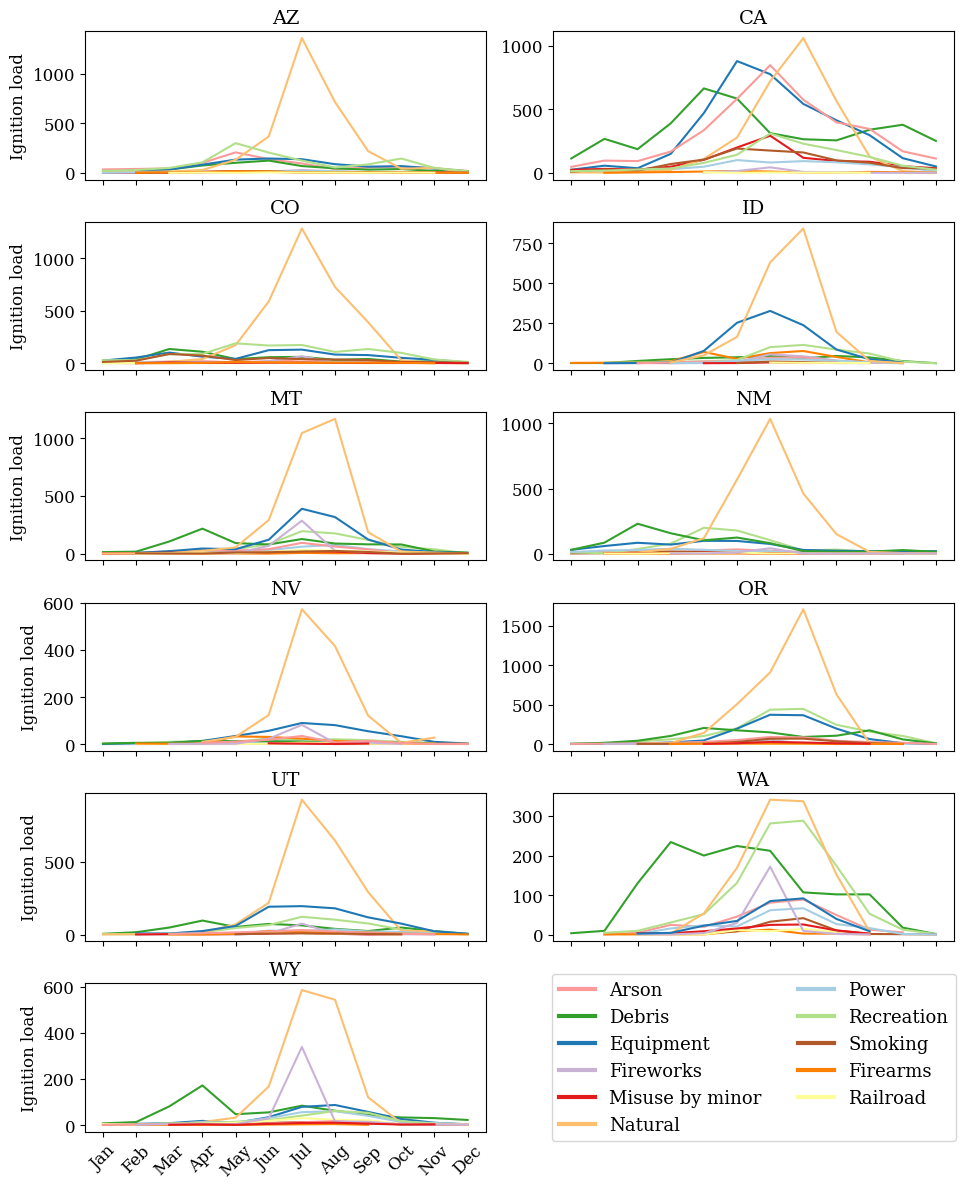

In [18]:
fig, axes = plt.subplots(ncols=2, nrows=6, sharex=True, sharey=False, figsize=(5*2, 2*6))
ax = axes.flatten()
for i, st in enumerate(sts[:]):
    temp = total[total['STATE'] == st]
    sns.lineplot(data=temp,
                 x='month',
                 y='counts',
                 hue='NWCG_GENERAL_CAUSE',
                 ax=ax[i],
                 palette=newCmapp,
                 legend=False)
    
    ax[i].set_title(label=st, fontsize=14)
    ax[i].set_xlabel('')
    ax[i].set_ylabel(ylabel='Ignition load', fontsize=12)
    ax[i].tick_params(axis='both', labelsize=12)
    ax[i].tick_params(axis='x', rotation=45)
    if i % 2 == 1:
        ax[i].set_ylabel('')
    
ax[-1].axis('off')
legend = ax[-1].legend(handles, labels, loc='center', ncol=2, fontsize=13)
for line in legend.get_lines():
    line.set_linewidth(3)

plt.tight_layout()
plt.show()